In [37]:
import os
import cv2
import pickle	# Used to save variables
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm	# Used to display progress bar
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator	# Used to generate images

np.random.seed(22)

In [38]:
def load(path, pneumonia):
    files = np.array(os.listdir(path))
    if pneumonia:
        labels = np.array([file.split('_')[1] for file in files])
    else:
        labels = np.array(['normal']*len(files))

    images = []
    for image in tqdm(files):
		# Read image
        image = cv2.imread(os.path.join(path, image))
		# Resize image to 200x200 px
        image = cv2.resize(image, dsize=(200,200))
		# Convert to grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(image)
        
    images = np.array(images)
    
    return images, labels



In [39]:
print('Loading train images')
# All images are stored in _images, all labels are in _labels
norm_images, norm_labels = load(f"C:\\Users\\SaahitiP\\Desktop\\ML4HC\\chest_xray\\train\\NORMAL", False)
pneu_images, pneu_labels = load(f"C:\\Users\\SaahitiP\\Desktop\\ML4HC\\chest_xray\\train\\PNEUMONIA", True)
# Put all train images to X_train 
X_train = np.append(norm_images, pneu_images, axis=0)
#labels to y_train
y_train = np.append(norm_labels, pneu_labels)

print('Loading test images')
norm_images_test, norm_labels_test = load(f"C:\\Users\\SaahitiP\\Desktop\\ML4HC\\chest_xray\\test\\NORMAL", False)
pneu_images_test, pneu_labels_test = load(f"C:\\Users\\SaahitiP\\Desktop\\ML4HC\\chest_xray\\test\\PNEUMONIA", True)
X_test = np.append(norm_images_test, pneu_images_test, axis=0)
y_test = np.append(norm_labels_test, pneu_labels_test)

print('Loading val images')
norm_images_val, norm_labels_val = load(f"C:\\Users\\SaahitiP\\Desktop\\ML4HC\\chest_xray\\val\\NORMAL", False)
pneu_images_val, pneu_labels_val = load(f"C:\\Users\\SaahitiP\\Desktop\\ML4HC\\chest_xray\\val\\PNEUMONIA", True)
X_val = np.append(norm_images_val, pneu_images_val, axis=0)
y_val = np.append(norm_labels_val, pneu_labels_val)

Loading train images


100%|██████████| 3875/3875 [00:30<00:00, 126.86it/s]


Loading test images


100%|██████████| 390/390 [00:02<00:00, 143.05it/s]


Loading val images


100%|██████████| 8/8 [00:00<00:00, 69.43it/s]


#### Investigating the data

In [40]:
import pandas as pd
def visualize_training_samples(y, train):
    my_colors = ['r', 'g','b']
    uniquetr, class_distribution = np.unique(y, return_counts=True)
    class_distribution = pd.Series(class_distribution)
    class_distribution.plot(kind='bar', color=my_colors)
    plt.xlabel('Class')
    plt.ylabel('Data points per Class')
    if train:
        plt.title('Distribution of points in train data')
    else:
        plt.title('Distribution of points in test data')
    plt.grid()
    plt.show()
    sorted_yi = np.argsort(-class_distribution.values)
    for i in sorted_yi:
        print('Number of data points in class', i+1, ':', class_distribution.values[i], '(', np.round((class_distribution.values[i]/len(y)*100), 3), '%)')
        print('-'*80)


(5216, 200, 200)
(5216,)
(array(['bacteria', 'normal', 'virus'], dtype='<U8'), array([2530, 1341, 1345], dtype=int64))
Display some samples: 


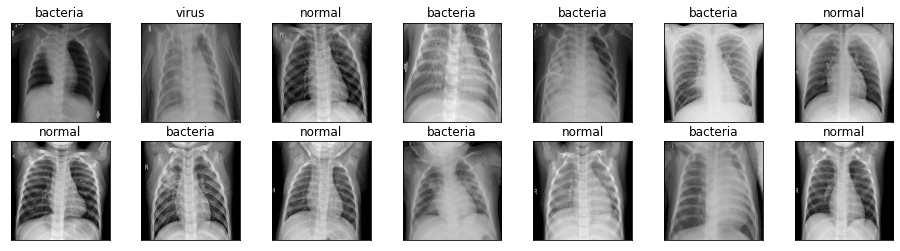

Visualizing training distribution ['bacteria':0, 'normal':1, 'viral': 2]: 


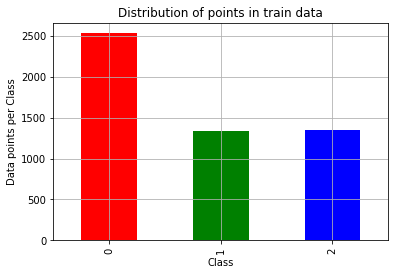

Number of data points in class 1 : 2530 ( 48.505 %)
--------------------------------------------------------------------------------
Number of data points in class 3 : 1345 ( 25.786 %)
--------------------------------------------------------------------------------
Number of data points in class 2 : 1341 ( 25.709 %)
--------------------------------------------------------------------------------


In [41]:
print(X_train.shape)
print(y_train.shape)
# Finding out the number of samples of each class
print(np.unique(y_train, return_counts=True))

print('Display some samples: ')
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))

indices = np.random.choice(len(X_train), 14)
counter = 0

for i in range(2):
    for j in range(7):
        axes[i,j].set_title(y_train[indices[counter]])
        axes[i,j].imshow(X_train[indices[counter]], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        counter += 1
plt.show()

print('Visualizing training distribution [\'bacteria\':0, \'normal\':1, \'viral\': 2]: ')
visualize_training_samples(y_train, True)

As one can see, the dataset is **highly imbalanced**, in the sense that there are more x ray images displaying signs of pneumonia, than there are healthy ones (there also seem to be more cases of bacterial pneumonia than viral ones). This is perhaps due to the fact that in pneumonia detection, false positives might have less detrimental effects than false negatives. However, in order to train an accurate model, we should still try to combat the data imbalance by performing data augmentation. 

From now on, we won't distinguish between bacterial pneumonia and viral pneumonia anymore.

(array(['normal', 'pneumoni'], dtype='<U8'), array([1341, 3875], dtype=int64))
Display some images: 


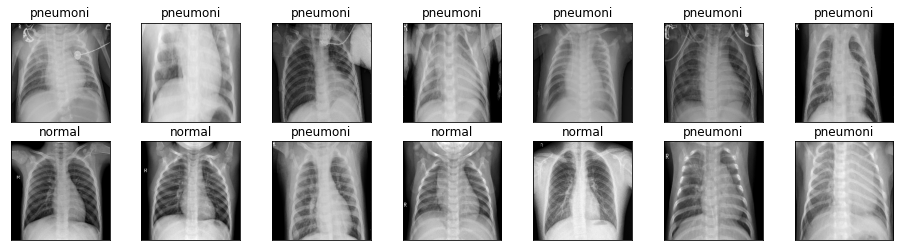

Visualizing training distribution ['normal':0, 'pneumonia': 1]: 


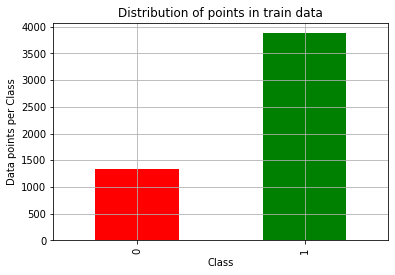

Number of data points in class 2 : 3875 ( 74.291 %)
--------------------------------------------------------------------------------
Number of data points in class 1 : 1341 ( 25.709 %)
--------------------------------------------------------------------------------


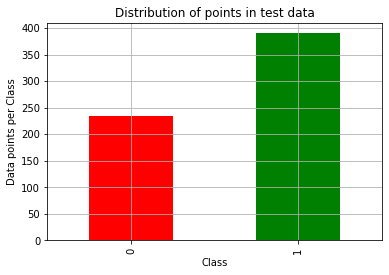

Number of data points in class 2 : 390 ( 62.5 %)
--------------------------------------------------------------------------------
Number of data points in class 1 : 234 ( 37.5 %)
--------------------------------------------------------------------------------


In [42]:
# we dont want to distinguish between different types of pneumonia, so the label 'bacteria' and 'virus' are replaced by 'pneumonia'
y_train[y_train == 'bacteria'] = 'pneumonia'
y_train[y_train == 'virus'] = 'pneumonia'

y_test[y_test == 'bacteria'] = 'pneumonia'
y_test[y_test == 'virus'] = 'pneumonia'

y_val[y_val == 'bacteria'] = 'pneumonia'
y_val[y_val == 'virus'] = 'pneumonia'

print(np.unique(y_train, return_counts=True))

print('Display some images: ')
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))

indices = np.random.choice(len(X_train), 14)
counter = 0

for i in range(2):
    for j in range(7):
        axes[i,j].set_title(y_train[indices[counter]])
        axes[i,j].imshow(X_train[indices[counter]], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        counter += 1
plt.show()

print('Visualizing training distribution [\'normal\':0, \'pneumonia\': 1]: ')
visualize_training_samples(y_train, True)
visualize_training_samples(y_test, False)

In [43]:
# Save the loaded images to pickle file for future use
with open('pneumonia_data.pickle', 'wb') as f:
    pickle.dump((X_train, X_test, X_val, y_train, y_test, y_val), f)
# Here's how to load it
with open('pneumonia_data.pickle', 'rb') as f:
    (X_train, X_test, X_val, y_train, y_test, y_val) = pickle.load(f)

### Preprocessing steps

##### 1. Pixel Normalization
For most image data, pixel values are integers with values between 0 to 255.  Normalizing pixels would shrink the integers to values between 0 to 1, and since inputs with larger values slow down the learning process, it might be a good practice to ensure efficient computation.

##### 2. Data Augmentation

(see below for details)

##### 3. RGB to Grayscale Conversion

Convert our images from RGB (3 dimensions) to grayscale (1 dimension). This could decrease the complexity of the model, as the model needs to learn many attributes of the images, such as edges, shapes, pattern, texture, shadows, brightness, contrast, etc., while also considering colors. This was done while reading in the data (above).

##### 4.  Reshaping of data 

Was also done while reading in the data

In [44]:
print('Label preprocessing')

# Create new axis on all y data
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]
y_val = y_val[:, np.newaxis]

# Initialize OneHotEncoder object
one_hot_encoder = OneHotEncoder(sparse=False)

# Convert all labels to 0 and 1
y_train_one_hot = one_hot_encoder.fit_transform(y_train)
y_test_one_hot = one_hot_encoder.transform(y_test)
y_val_one_hot = one_hot_encoder.transform(y_val)


print('Reshaping X data')
# Reshape the data into (no of samples, height, width, 1), where 1 represents a single color channel
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)


Label preprocessing
Reshaping X data


In [45]:
print(y_train_one_hot)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


# Data Augmentation

Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset. Training deep learning neural network models on more data can result in more skillful models, and the augmentation techniques can create variations of the images that can improve the ability of the models to generalize what they have learned to new images. The Keras deep learning neural network library provides the capability to t models using image data augmentation via the ImageDataGenerator class. We implemented Horizontal/Vertical Shift, Rotation, and Zoom Augmentation.

**height_shift_range** : controls the amount of vertical shift (similarly, **width_shift_range**)

**rotation_range** : rotations to the image between 0 and 90 degrees.

**zoom_range**: A zoom augmentation randomly zooms the image in and either add new pixel values around the image.



In [46]:
print('Data augmentation')
# Generate new images with some randomness
datagen = ImageDataGenerator(
		rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train_one_hot, batch_size = 32)

Data augmentation


# CNN Model : Training

Simple model using the Functional API from Keras, designed in a sequential manner. The input layer takes all the image samples in our X data, so it accepts the exact same shape as the image size (200). It's defined by (width, height, channels), w single grayscale channel.

input1 layer is connected to convolution-pooling layer pairs before eventually being flattened and connected to dense layers. All the hidden layers in the model usethe ReLU activation function due to the fact that ReLU is faster to compute compared to sigmoid, and thus, the training time required is shorter. Lastly, the last layer to connect is output1, which consists of 3 neurons with a softmax activation function. max pooling with pool size (2,2).

Here softmax is used because we want the outputs to be the probability value of each class.

next step: batch normalization to prevent overfitting

In [47]:
#alternative

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the input shape. Since the input shape needs only the dimensions of a single sample, 
# it takes the height, width, and number of channels (1 in this case, for grayscale images) from the training data
input_shape = (X_train.shape[1], X_train.shape[2], 1)
print(input_shape)

# Define the model. There are four convolutional layers, with varying numbers of filters (16 or 32) and 
# kernel sizes (3x3 or 2x2). All of them use a stride of 1x1 and 'same' padding, which means the output size 
# will be the same as the input size after applying the convolution. 
# The activation function used is 'ReLU' (Rectified Linear Unit)

model = Sequential([
    Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=input_shape),
    Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D((2, 2)), # reduces height&width of image by half
    Conv2D(16, kernel_size=(2, 2), activation='relu', strides=(1, 1), padding='same'),
    Conv2D(32, kernel_size=(2, 2), activation='relu', strides=(1, 1), padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(), # flattens 2D output of the last max-pooling layer into 1D array
    Dense(100, activation='relu'), #fully connected layer with 100 neurons
    Dense(50, activation='relu'),
    Dense(2, activation='softmax') #bcos of 2 classes. If we distinguish between viral and bacterial, set to 3
])


(200, 200, 1)


In [48]:
#model = Model(inputs=input1, outputs=output1)

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['acc'])

# Using fit_generator() instead of fit() because we are going to use data
# taken from the generator. Note that the randomness is changing
# on each epoch
history = model.fit_generator(train_gen, epochs=3, 
          validation_data=(X_val, y_val_one_hot))

# Saving model
model.save('pneumonia_cnn.h5')


Epoch 1/3


C:\Users\SaahitiP\AppData\Local\Temp\ipykernel_25448\2591549194.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, epochs=3,


163/163 [==============================] - 127s 778ms/step - loss: 1.6751 - acc: 0.8275 - val_loss: 0.5897 - val_acc: 0.6875
Epoch 2/3
163/163 [==============================] - 134s 819ms/step - loss: 0.2420 - acc: 0.8959 - val_loss: 0.5955 - val_acc: 0.7500
Epoch 3/3
163/163 [==============================] - 130s 797ms/step - loss: 0.2215 - acc: 0.9099 - val_loss: 0.3338 - val_acc: 0.7500


Displaying accuracy


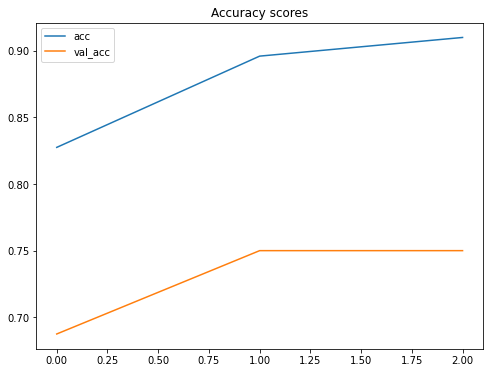

Displaying loss


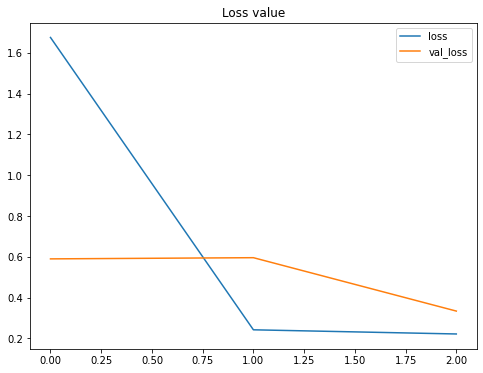

In [49]:
print('Displaying accuracy')
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.show()

print('Displaying loss')
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

# CNN Model: Evaluation

[[0.37064376 0.62935627]
 [0.3304497  0.66955036]
 [0.07506456 0.92493546]
 ...
 [0.00256577 0.9974342 ]
 [0.04044777 0.9595522 ]
 [0.49575382 0.5042461 ]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Model evaluation
[array(['normal', 'pneumoni'], dtype='<U8')]


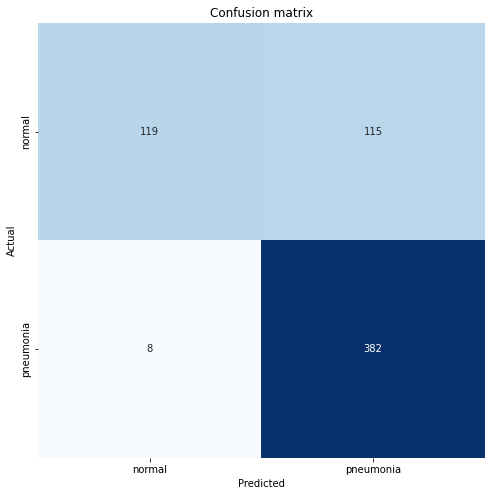

In [50]:
from sklearn.metrics import f1_score
# Predicting test data
predictions = model.predict(X_test)
print(predictions)

print(y_test_one_hot)

predictions_ = one_hot_encoder.inverse_transform(predictions)
print('Model evaluation')
print(one_hot_encoder.categories_)

classnames = ['normal', 'pneumonia']

# Display confusion matrix: table that shows the number of true positive, true negative, false positive, 
# and false negative predictions. it provides a comprehensive view of the model's performance and can help 
# identify specific issues with the classification.
cm = confusion_matrix(y_test, predictions_)
plt.figure(figsize=(8,8))
plt.title('Confusion matrix')
sns.heatmap(cm, cbar=False, xticklabels=classnames, yticklabels=classnames, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [51]:

# given the class imbalance, we evaluate the model using f1 score, since it balances precision and recall and is probably
# more important in this case than accuracy
predictions_[predictions_ == 'pneumoni'] = 1
predictions_[predictions_ == 'normal'] = 0

y_test[y_test == 'pneumoni'] = 1
y_test[y_test == 'normal'] = 0


print(y_test[0])
print(predictions_[0])

f1 = f1_score(y_test, predictions_)
print("F1-score:", f1)



['0']
['1']


ValueError: pos_label=1 is not a valid label. It should be one of ['0', '1']